# Project 2 ML

Modules

In [1]:
##################################################################################################################################
'''                                             IMPORTING GENERAL LIBRARIES                                                   '''
##################################################################################################################################
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import time
import timeit
##################################################################################################################################
'''                                      IMPORTING SCIKIT-LEARN METHODS AND MODULES                                          '''
##################################################################################################################################
##################################################################
'''                 FEATURE EXTRACTION                       '''
##################################################################
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer
##################################################################
'''                 FEATURE SELECTION                       '''
##################################################################
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
##################################################################
'''                     CLASSIFIERS                        '''
##################################################################
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
##################################################################
'''           PIPELINE, GRID SEARCH AND METRICS             '''
##################################################################
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
##################################################################
'''                     NLTK LIBRARY MODULES                 '''
##################################################################
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize 
from nltk.stem import WordNetLemmatizer


Read and manage data

In [2]:
##################################################################################################################################
'''                                 GENERAL FUNCTIONS TO READ, WRITE AND HABDLE DATA                                        '''
##################################################################################################################################

def Read_File_DF(File_Name, separation=",", head=None, replace=[], drop=False):
    """ Function created to read dataset files and import information as a Pandas DataFrame
    INPUT: Dataset file name, character delimiter in the file (default ','), flag for file header (default 0 - no header head=None),
            list of strings to find possible malformations (default empty) and flag to drop or not lines/columns
            containing such values (default False)"""
    try:
        separation = separation.lower()
        if(separation == "space" or separation == "tab"):
            separation = "\t"
        Raw_Data_Set = pd.read_csv(File_Name, delimiter=separation, header=head, na_values=replace)
        RawRowsColumns = Raw_Data_Set.shape
        if(replace != None):
            Missing = Raw_Data_Set.isnull().sum().sum()
            print("Total number of missing/anomalous 'entries' in the data set: ",Missing)
            if(drop == True):
                Raw_Data_Set.dropna(axis=0, how='any', inplace=True)
                CleanRowsColumns = Raw_Data_Set.shape
                print("Number of examples with missing values deleted from data set: ",(RawRowsColumns[0]-CleanRowsColumns[0]))
        return Raw_Data_Set
    except:
        print("READ_FILE_ERROR\n")

def Write_File_DF(Data_Set, File_Name="Predictions", separation=",", head=True, ind=False, dec='.'):
    """ Function created to write a Pandas DataFrame containing prediciton made by classifiers to submit to competition
    INPUT: DataFrame with IDs and predictions, file name (default 'Predictions'), character delimiter in the file (default ','), 
            flag to include file header (default True), flag to include column of indices (default False)
            and character for decimals (default '.') """
    try:
        separation = separation.lower()
        if(separation == "space" or separation == "tab"):
            separation = "\t"
        timestr = time.strftime("%y-%m-%d_%Hh%Mm%Ss_")
        name = timestr+File_Name+".csv"
        Data_Set.to_csv(path_or_buf=name, sep=separation, na_rep='', float_format=None, columns=None, header=head, index=ind,
                        index_label=None, mode='w', encoding=None, compression='infer', quoting=None, quotechar='"',
                        line_terminator=None, chunksize=None, date_format=None, doublequote=True, escapechar=None, decimal=dec)
        return print("Predictions for classes exported as csv file")
    except:
        print("WRITE_FILE_ERROR\n")

def To_PD_DF(Data_Set):
    """ Function created to convert NumPy array to Pandas DataFrame 
    INPUT: NumPy array/matrix containing data """
    try:
        Data_Set_DF = pd.DataFrame(Data_Set, index = (list(range(0,Data_Set.shape[0]))), columns = (list(range(0,Data_Set.shape[1]))))
        return Data_Set_DF
    except:
        print("DATAFRAME_CONVERT_ERROR\n")
    
def To_NP_Array(Data_Set):
    """ Function created to convert Pandas DataFrame to NumPy array/matrix 
    INPUT: Pandas DataFrame containing data """
    try:
        Data_Set_NP = Data_Set.to_numpy(copy = True)
        return Data_Set_NP
    except:
        print("NP_CONVERT_ERROR\n")

In [3]:
def Count_Plot(Column, Dataset, Cond=None, TitleName="MyPlot", Color=None, save=False):
    sb.set(style="whitegrid", color_codes=True) # set the background colour of the plot to white
    sb.set(rc={"figure.figsize":(25,20)}) # setting the plot size for all plots
    ax = sb.countplot(Column,data=Dataset, hue=Cond, color=Color) # create a countplot ,hue = 'Opportunity Result'
    ax.set_title(TitleName, fontsize = 35)
    #sb.despine(offset=10, trim=True) # Remove the top and down margin
    plt.show() # display the plot
    if(save==True):
        fig = ax.get_figure()
        fig.savefig(TitleName+".png")

Calling data

In [4]:
FileTrain = "reddit_train.csv"
dataTrain = Read_File_DF(FileTrain, separation=',', head=0, replace=None, drop=False) #Reading file
dataTrain.head(n=5)

,id,comments,subreddits
0,0,"Honestly, Buffalo is the correct answer. I rem...",hockey
1,1,Ah yes way could have been :( remember when he...,nba
2,2,https://youtu.be/6xxbBR8iSZ0?t=40m49s\n\nIf yo...,leagueoflegends
3,3,He wouldn't have been a bad signing if we woul...,soccer
4,4,Easy. You use the piss and dry technique. Let ...,funny


In [5]:
dataTrain.tail(n=5)

,id,comments,subreddits
69995,69995,"Thank you, you confirm Spain does have nice pe...",europe
69996,69996,Imagine how many he would have killed with a r...,leagueoflegends
69997,69997,Yes. Only. As in the guy I was replying to was...,canada
69998,69998,Looking for something light-hearted or has a v...,anime
69999,69999,I love how I never cry about casters because I...,GlobalOffensive


General information about subreddit classes

In [6]:
print(dataTrain["subreddits"].describe())

count     70000
unique       20
top       trees
freq       3500
Name: subreddits, dtype: object


Looking at frequency of each subreddit class

In [7]:
clas = dataTrain["subreddits"].unique().tolist()
fr = []
for sub in clas:
    fr.append(dataTrain["subreddits"].str.count(sub).sum())
Freq = pd.DataFrame({"subreddits":clas,"frequency":fr})
print(Freq)

         subreddits  frequency
0            hockey       3500
1               nba       3500
2   leagueoflegends       3500
3            soccer       3500
4             funny       3500
5            movies       3500
6             anime       3500
7         Overwatch       3500
8             trees       3500
9   GlobalOffensive       3500
10              nfl       3500
11        AskReddit       3500
12    gameofthrones       3500
13       conspiracy       3500
14        worldnews       3500
15              wow       3500
16           europe       3500
17           canada       3500
18            Music       3500
19         baseball       3500


Histogram for subreddits' distribution

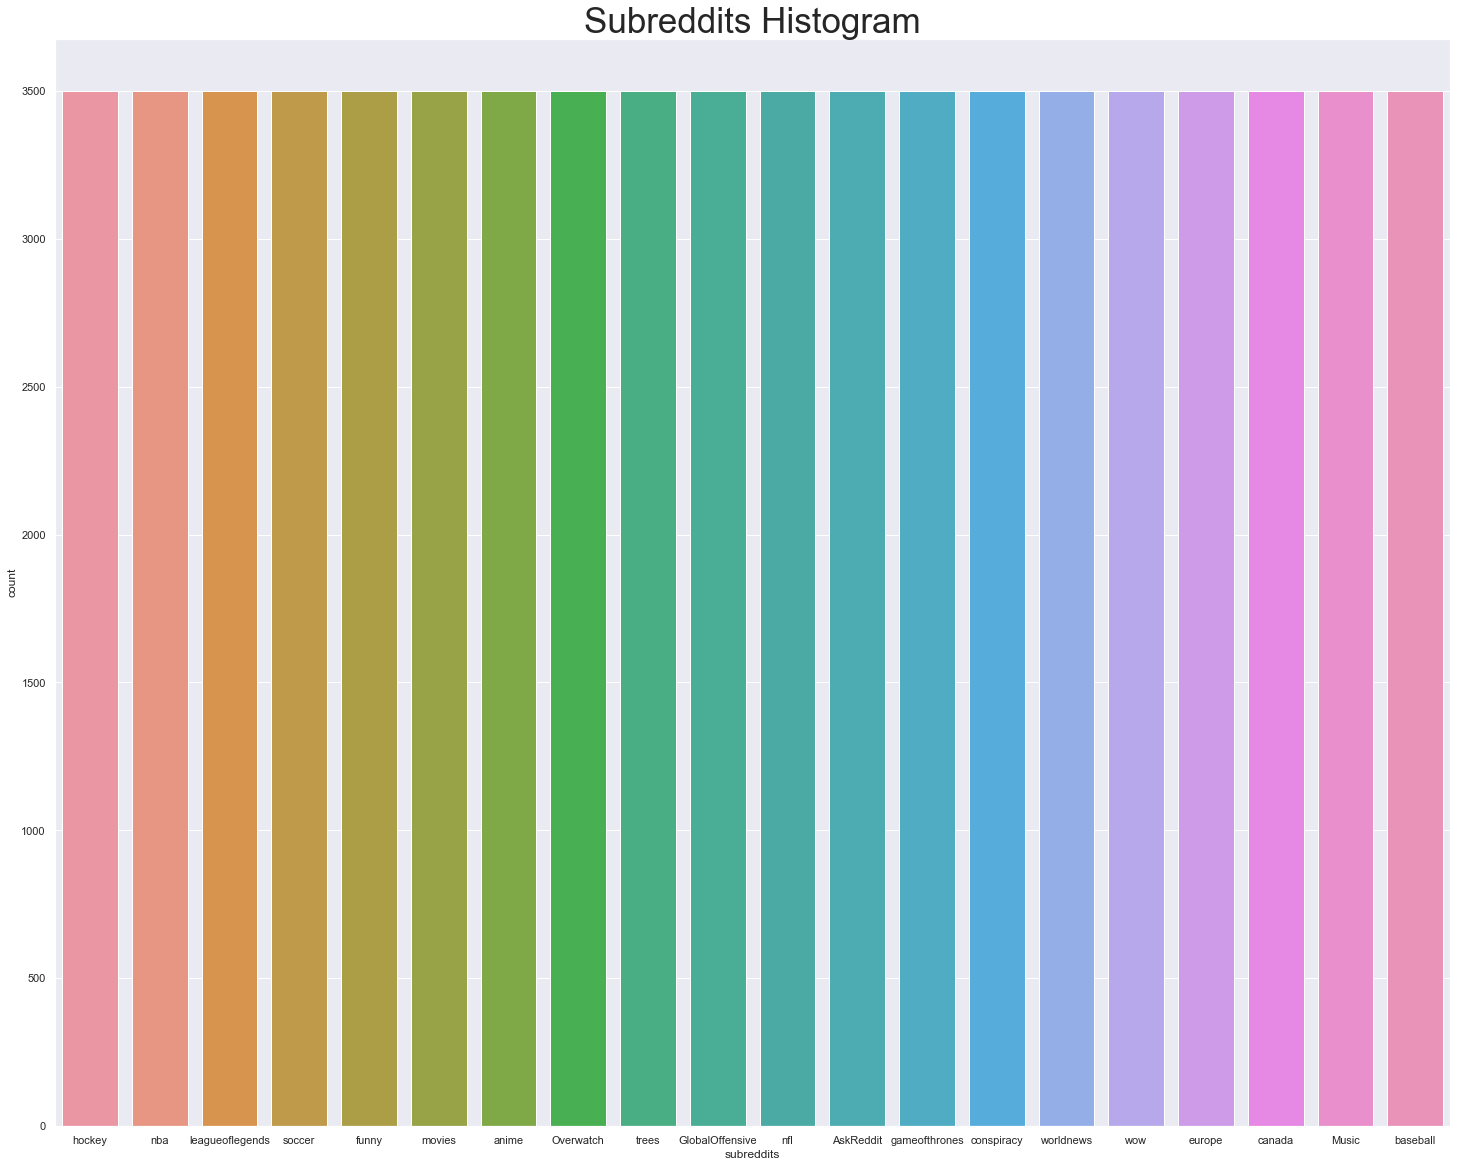

In [8]:
Count_Plot(Column="subreddits", Dataset=dataTrain, TitleName="Subreddits Histogram", save=False)

Dividing the dataset into a training and a test set

In [9]:
target = dataTrain["subreddits"]
features = dataTrain.iloc[:,[0,1]]

from sklearn.model_selection import train_test_split
data_train, data_test, out_train, out_test = train_test_split(features,target, test_size=0.30, random_state=106750, shuffle=True, stratify=target)

data_train.tail(n=10)

,id,comments
11975,11975,"/u/sfoxx, your post has been removed as this a..."
25159,25159,I would take Charlotte over Philadelphia for s...
60336,60336,EVERYONE is treated by Israel. That's what Isr...
50911,50911,Very true. I was lazy and couldn't be bothere...
46228,46228,Scheifele... Well have to win cups and he'll h...
53853,53853,And he was a negative defender pretty much eve...
46305,46305,He chased the dreams further and further in to...
55633,55633,"Or you should just, like, go with the flow man"
35605,35605,I want a support that is a little monkey who r...
55813,55813,We did for several games in a row. Never met a...


In [10]:
print(data_train.iloc[48992,1])
print(out_train.iloc[48992])

EVERYONE is treated by Israel. That's what Israeli doctors do. Your statement has no cause to be an accusation. 
worldnews


Vectorizing the features - CountVectorizer or TF–IDF term weighting

In [11]:
def ExtractVectorizer(DataTrain, DataTest, CountVecXTFIDF=True, Accents=None, Token=None, Stop=None, nGram=None, Binar=False,
                      Regular='l2', Normal=False, SubLinear=False, AdditFeat=None, show=False):
    """ Function imports method CountVectorizer and TfidfVectorizer from scikit-learn to extract text features
    INPUT: training examples' features, testing examples' features, flag for choosing extractor (default True -> CountVectorizer),
            string for strip accents (default None), tokenizer method (default none), list containing set of stop_words (default None),
            the tupple fortusing n-grams (default None -> (1,1)), flag to binarize CountVectorizer, regularization method for Tfidf (default 'l2'),
            flag to normalize or not the extracted features (default False), flag for sublinear tf (default False), additional features
            which are not to be fitted (default None) and flag for showing resulting vectors (default False)
    OUTPUT: Vector of fitted training features and vector of transformed test features """
    try:
#        Default arguments CountVectorizer -> (encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True,
#                                              preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\b\w\w+\b',
#                                              ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None,
#                                              vocabulary=None, binary=False)
#        Default arguments TfidfVectorizer -> (encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True,
#                                              preprocessor=None, tokenizer=None, analyzer='word', stop_words=None,
#                                              token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), max_df=1.0, min_df=1,
#                                              max_features=None, vocabulary=None, binary=False, norm='l2', use_idf=True,
#                                              smooth_idf=True, sublinear_tf=False)
        if(nGram==None):
            nGram = (1,1)
        
        if(CountVecXTFIDF==True):
            vectorizing = CountVectorizer(strip_accents=Accents, tokenizer=Token, stop_words=Stop, ngram_range=nGram, binary=Binar)
            print("Vectorizer selected:",vectorizing)
        elif(CountVecXTFIDF==False):
            vectorizing = TfidfVectorizer(strip_accents=Accents, tokenizer=Token, stop_words=Stop, ngram_range=nGram, binary=Binar,
                                          norm=Regular, sublinear_tf=SubLinear)
            print("Vectorizer selected:",vectorizing)
        
        vector_training = vectorizing.fit_transform(DataTrain) #Vectorizing vocabulary for training set and fitting        
        vector_testing = vectorizing.transform(DataTest) #Vectorizing vocabulary for test set and transforming - only transforming, or else we would train in the test data also
        
        if(AdditFeat!=None):
            from scipy.sparse import hstack
            vector_additional = vectorizing.transform(AdditFeat)
            vector_training = hstack((vector_training, vector_additional))
            print("All features assembled.\n")
        
        if(Normal==True):
            vector_training = normalize(vector_training) #Normalizing vector for training set        
            vector_testing = normalize(vector_testing) #Normalizing vector for training set
            print("Data normalized.\n")
        
        if(show==True):
            print("Mapping of terms:",vectorizing.vocabulary_) #Vocabulaty from the vectorization
            print("List of stop words used:",vectorizing.stop_words_) #Terms ignored in the vectorization
            if hasattr(vectorizing, 'idf_'):
                print("Inverse document frequency:",vectorizing.idf_) #Inverse document frequency from the vectorization
        return vector_training, vector_testing
    except:
        print("VECTORIZER_ERROR\n")

In [12]:
""" Different Parameters to be used in the vectorizer """
#Stops = 'english'
Strips = 'unicode'
#Strips = 'ascii'
#Tokens = pf.LemmatizerTokens()
#NGrams = (1,2)
Stops = None
#Strips = None
Tokens = None
NGrams = None

In [13]:
vector_training, vector_testing = ExtractVectorizer(DataTrain=data_train["comments"], DataTest=data_test["comments"], CountVecXTFIDF=False,
                                                 Accents=Strips, Token=Tokens, Stop=NGrams, nGram=NGrams, Binar=True, Regular='l1',
                                                 Normal=False, SubLinear=True, AdditFeat=None, show=False)
print(vector_training,"\n", vector_testing)

Vectorizer selected: TfidfVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l1', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='unicode',
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)
  (0, 20506)	0.13450346488300532
  (0, 28802)	0.14657556141696548
  (0, 54380)	0.04771684541076506
  (0, 59453)	0.07260273304581083
  (0, 14905)	0.1296344620245622
  (0, 20725)	0.11651540512992065
  (0, 30221)	0.05208278021614683
  (0, 38100)	0.06980630844111088
  (0, 10344)	0.0456523434875406
  (0, 13901)	0.1062014079436651
  (0, 42673)	0.07870868800050712
  (1, 13338)	0.016810535334324885
  (1, 39088)	0.00954317386847193
  (1, 43845)	0.016320768435281633
  (1, 5695)	0.012036

Defining list of possible classification models

In [14]:
ListClassifiers = [("LogisticRegression", LogisticRegression(penalty='elasticnet', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                                             intercept_scaling=1, class_weight=None, random_state=None, solver='saga',
                                                             max_iter=1500, multi_class='auto', verbose=0, warm_start=False, n_jobs=-1,
                                                             l1_ratio=0.75))
                   ,("LinearSVC", LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1,
                                           loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l1', random_state=None,
                                           tol=0.0001,verbose=0))
                   ,("SGD_Classifier", SGDClassifier(alpha=0.000001, average=False, class_weight=None, early_stopping=False, epsilon=0.1,
                                                     eta0=0.0, fit_intercept=True, l1_ratio=0.75, learning_rate='optimal', loss='hinge',
                                                     max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='elasticnet', power_t=0.5,
                                                     random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False))
                   ,("Bernoulli_Naive_Bayes", BernoulliNB(alpha=1.0))
                   ,("Multinomial_Naive_Bayes", MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))
                   ,("kNearest_Neighbors", KNeighborsClassifier(n_neighbors=15))
                   ,("Random_Forest", RandomForestClassifier(n_estimators=1000, bootstrap=True, class_weight=None, criterion='gini',
                                                             max_depth=None, max_features='auto', max_leaf_nodes=None,
                                                             min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=2,
                                                             min_samples_split=2, min_weight_fraction_leaf=0.0, n_jobs=-1, oob_score=False,
                                                             random_state=None, verbose=0, warm_start=False))
                   ]

Function to fit model and make predictions

In [15]:
def Classification_Model(data_training, target_training, data_testing, Classifier, target_testing=None, ModelName="Classifier", accur=False, grph=False, setClass=None, show=False):
    """ Function created to receive a classification model from Scikit-Learn library and perform the fittinf and predicting steps.
    INPUT: training examples' features, training examples' outputs, testing examples' features, testing examples' outputs if performing held out
            validation (default None), classifier name, flag for printing accuracy in case of validation (default False), flag for printing
            classification reports (default grph=False) from ClassReport_Graph funciton, list with the names of the classes (if grph=True) 
            and flag fo showing classifier's attributes (default False) """
    try:
        print("Classifier selected: ", Classifier)
        print("-"*100)
        Classifier.fit(data_training, target_training) #Object of type Classifier training model
        preds = Classifier.predict(data_testing) #Object of type Classifier predicting classes
        if(accur==True):
            print((ModelName+" accuracy: "),metrics.accuracy_score(target_testing, preds, normalize=True))
        if(grph==True):
            ClassReport_Graph(Classif=Classifier, Data_train=data_training, Target_train=target_training, Data_test=data_testing, Target_test=target_testing, Class=setClass)
        if(show==True):
            Parameters = Classifier.get_params
            if(Classifier==LogisticRegression(Parameters)):
                print("Class labels:\n",Classifier.classes_) #List of class labels
                print("Features' coefficients:\n",Classifier.coef_) #Coefficient of the features in the decision function
                print("Bias added:\n",Classifier.intercept_) #Bias added to the classification function       
            elif(Classifier==LinearSVC(Parameters)):
                print("Features' weights:\n",Classifier.coef_) #Coefficients of the features in the primal problem
                print("Intercept constants:\n",Classifier.intercept_) #Bias added to the classification function
            elif(Classifier==SGDClassifier(Parameters)):
                print("Features' weights:\n",Classifier.coef_) #Coefficients of the features in the primal problem
                print("Intercept constants:\n",Classifier.intercept_) #Bias added to the classification function
                print("Loss function:\n",Classifier.loss_function_) #Loss function used
            elif(Classifier==BernoulliNB(Parameters)):
                print("The log probability of each class:\n",Classifier.class_log_prior_) #Smoothed log probability of each class
                print("Log probability of features given a class:\n",Classifier.feature_log_prob_) #Empirical log probability of features given a class, P(x_i|y)
                print("Number of samples obs.:\n",Classifier.class_count_) #Number of training samples observed in each class
                print("Number samples for each class/feat.:\n",Classifier.feature_count_) #Number of samples encountered for each (class, feature) during fitting
            elif(Classifier==MultinomialNB(Parameters)):
                print("The log probability of each class:\n",Classifier.class_log_prior_) #Smoothed log probability of each class
                print("Log probability of features given a class:\n",Classifier.feature_log_prob_) #Empirical log probability of features given a class, P(x_i|y)
                print("Number of samples obs.:\n",Classifier.class_count_) #Number of training samples observed in each class
                print("Number samples for each class/feat.:\n",Classifier.feature_count_) #Number of samples encountered for each (class, feature) during fitting
            elif(Classifier==RandomForestClassifier(Parameters)):
                print("List of DT classifiers:\n",Classifier.estimators_) #The collection of fitted sub-estimators
                print("Score of the training dataset:\n",Classifier.oob_score_ ) #Score of the training dataset obtained using an out-of-bag estimate.
                print("Number of samples obs.classes:\n",Classifier.classes_) #The classes labels
            elif(Classifier==VotingClassifier(Parameters)):
                print("List of estimators stacked:\n",Classifier.estimators_) #The collection of fitted sub-estimators as defined in estimators that are not None
                print("Name to access estimators:\n",Classifier.named_estimators_ ) #Attribute to access any fitted sub-estimators by name
                print("Number of samples obs.:\n",Classifier.classes_) #The classes labels
        print("-"*100)
        return preds    
    except:
        print("CLASSIFIER-FIT/TEST_ERROR\n")

Running model

In [16]:
test_pred = Classification_Model(data_training=vector_training, target_training=out_train, data_testing=vector_testing,
                                    Classifier=ListClassifiers[4][1], target_testing=out_test, ModelName=ListClassifiers[4][0], accur=True,
                                    grph=False, setClass=clas, show=False)

Classifier selected:  MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
----------------------------------------------------------------------------------------------------
Multinomial_Naive_Bayes accuracy:  0.5506666666666666
----------------------------------------------------------------------------------------------------


Importing method to report and analyse predictions Logistic Regression

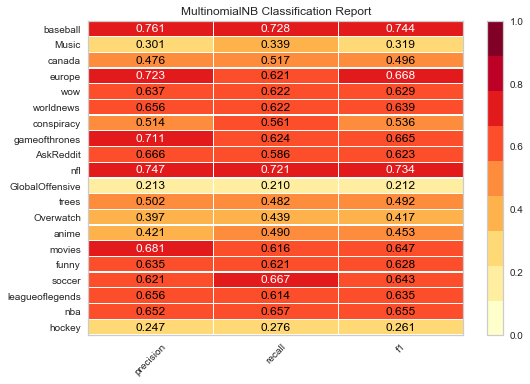

In [18]:
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(ListClassifiers[4][1], classes=clas)
visualizer.fit(vector_training, out_train) # Fit the training data to the visualizer
visualizer.score(vector_testing, out_test) # Evaluate the model on the test data
graph = visualizer.poof() # Draw/show/poof the data